# Analyzing Kickstarter Projects – A Deep Dive with SQL

## 1. Introduction

In this project, we'll pretend to take on the role of a data analyst at a startup. The product team is considering launching a campaign on [Kickstarter](https://www.kickstarter.com/) to test the viability of some offerings. 

<div>
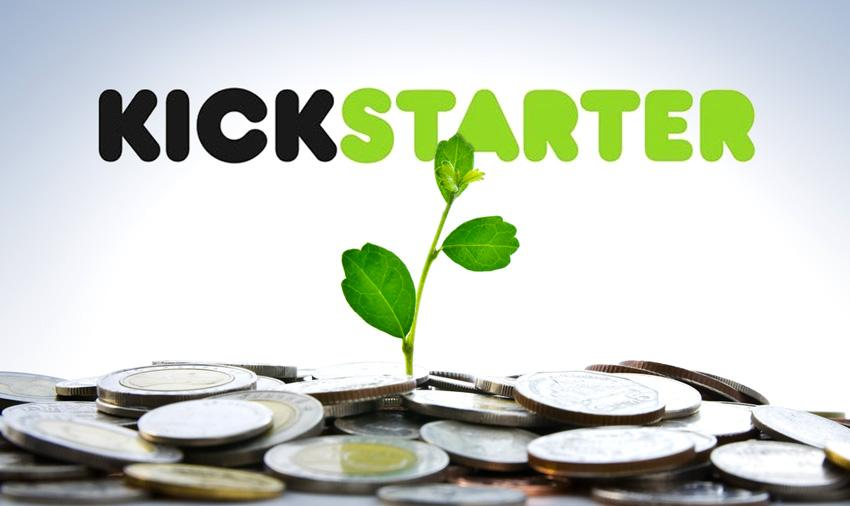
</div>

For a bit of background, Kickstarter is a crowdfunding platform where individuals and organizations can raise funds for creative projects, ranging from art and music to games and technology. In return for their support, backers often receive rewards or incentives, such as early access to the product or exclusive merchandise.

We've been tasked with gathering data to help our team understand what factors could impact the success of a campaign. The data will be sourced from a [selection of fields](https://www.kaggle.com/datasets/kemical/kickstarter-projects) on Kaggle. Specifically, we'll address the following two questions:

1. **What types of projects are most likely to be successful?**
2. **Which projects tend to fail?**

## 2. Retrieving Column Data Types

The first step to working with a database is understanding its contents. It's important to note that our database comprises only one table – `ksprojects`. So let's list the names and data types for this table.

In [1]:
# Import the relevant libraries
import sqlite3
import pandas as pd

# Connect to the SQLite database
conn = sqlite3.connect('Datasets/ks_projects.db')

# Write a SQL query to retrieve table information
query = "PRAGMA table_info(ksprojects);"

# Read the table information into a pandas DataFrame
data = pd.read_sql_query(query, conn)
data

,cid,name,type,notnull,dflt_value,pk
0,0,ID,INTEGER,0,None,0
1,1,name,TEXT,0,None,0
2,2,category,TEXT,0,None,0
3,3,main_category,TEXT,0,None,0
4,4,goal,REAL,0,None,0
5,5,pledged,REAL,0,None,0
6,6,state,TEXT,0,None,0
7,7,backers,INTEGER,0,None,0


The output provides a clear overview of the structure of the `ksprojects` table in the SQLite database:

- The `ID` column is of type `INTEGER` and indicates a Kickstarter project ID.
- The `name` column is of type `TEXT` and represents the name of each project.
- Both `category` and `main_category` columns are of type `TEXT`, storing information about the project's category and its broader category, respectively.
- The `goal` and `pledged` columns, being of type `REAL`, store numerical values indicating the fundraising goal and the amount pledged for each project.
- The `state` column is of type `TEXT` and indicates the status of each project – successful, canceled, etc.
- Lastly, the `backers` column, of type `INTEGER`, represents the number of backers for each project.

## 3. Initial Selection of Rows and Columns

From now on, we'll gradually begin constructing a query with several components until we have the final query. To start, even a database with just one table probably contains data that isn't necessary for our analysis. Therefore, we'll specify which columns to read from the table.

In [2]:
# Select specific columns from the 'ksprojects' table and limit the results to 10 rows
query = """SELECT main_category, goal, backers, pledged
             FROM ksprojects
            LIMIT 10;"""

# Read the query results into a pandas DataFrame
data = pd.read_sql_query(query, conn)
data

,main_category,goal,backers,pledged
0,Publishing,1000.0,0,0.00
1,Film & Video,30000.0,15,2421.00
2,Film & Video,45000.0,3,220.00
3,Music,5000.0,1,1.00
4,Film & Video,19500.0,14,1283.00
5,Food,50000.0,224,52375.00
6,Food,1000.0,16,1205.00
7,Food,25000.0,40,453.00
8,Design,125000.0,58,8233.00
9,Film & Video,65000.0,43,6240.57


From the output, we can draw several insights regarding Kickstarter projects:

- The projects span across various main categories, including `Film & Video`, `Publishing`, `Music`, and `Food`. This indicates a diverse range of creative endeavors seeking funding on the platform.
- Fundraising goals vary significantly among the projects, with values ranging from `1,000` to `125,000` USD. This suggests that projects on Kickstarter have a wide range of financial needs, from small-scale endeavors to ambitious ventures requiring substantial funding.
- The number of backers for these initial projects ranges from `0` to `224`, highlighting the varying levels of support each project has garnered. Projects with higher numbers of backers may indicate greater interest or engagement from the community.
- The pledged amounts also vary greatly, from `0.00` to `52,375.00` USD. This reflects the differing degrees of success in attracting financial support for the projects, with some surpassing their goals and others still in the early stages of fundraising.

Overall, these initial insights suggest a dynamic and diverse landscape of Kickstarter projects, each with its own goals, levels of support, and potential for success.

## 4. Filtering by Category

Let's continue building upon the previous query. Now that we've selected the relevant columns, we'll filter the data to include only those in certain categories.

[Thomas Edison](https://www.biography.com/inventors/thomas-edison) famously said, *"I have not failed. I've just found 10,000 ways that won't work."* With that in mind, our product team would like to learn more about the projects that weren't successful.

In [3]:
# Select specific columns from the 'ksprojects' table,
# filter the data to include only projects with states 'failed', 'canceled', or 'suspended',
# and limit the results to 10 rows
query = """SELECT main_category, backers, pledged, goal
             FROM ksprojects
            WHERE state IN ('failed', 'canceled', 'suspended')
            LIMIT 10;"""

# Read the query results into a pandas DataFrame
data = pd.read_sql_query(query, conn)
data

,main_category,backers,pledged,goal
0,Publishing,0,0.00,1000.0
1,Film & Video,15,2421.00,30000.0
2,Film & Video,3,220.00,45000.0
3,Music,1,1.00,5000.0
4,Film & Video,14,1283.00,19500.0
5,Food,40,453.00,25000.0
6,Design,58,8233.00,125000.0
7,Film & Video,43,6240.57,65000.0
8,Publishing,0,0.00,2500.0
9,Crafts,0,0.00,5000.0


From the output, we can derive several insights:

- The `failed`, `canceled`, or `suspended` projects span across various main categories, including `Film & Video`, `Design`, `Food`, and `Crafts`. This indicates a diverse range of project types experiencing setbacks.
- Despite the projects' states, there are variations in the number of backers and the amount pledged. Some projects have attracted significant support, while others have minimal to no backing.
- The goals set for these projects also vary widely, from relatively modest amounts to more ambitious targets.

## 5. Filtering by Quantity

For our analysis, we'll only want to focus on projects of a certain size. This is because there are many small projects in the database that are irrelevant to us. Now that we've filtered our records to meet certain categories, let's also refine the filter to meet specific quantity thresholds.

In [4]:
# Select specific columns from the 'ksprojects' table,
# filter the data to include only projects with states 'failed', 'canceled', or 'suspended',
# with at least 100 backers and a minimum pledged amount of $20,000,
# and limit the results to 10 rows
query = """SELECT main_category, backers, pledged, goal
             FROM ksprojects
            WHERE state IN ('failed', 'canceled', 'suspended')
              AND backers >= 100 AND pledged >= 20000
            LIMIT 10;"""

# Read the query results into a pandas DataFrame
data = pd.read_sql_query(query, conn)
data

,main_category,backers,pledged,goal
0,Technology,120,90771.00,250000.0
1,Design,647,39693.00,25000.0
2,Technology,103,61416.00,5000.0
3,Art,257,50230.00,100000.0
4,Film & Video,135,23098.00,150000.0
5,Film & Video,189,20677.00,50000.0
6,Film & Video,118,25877.00,100000.0
7,Technology,108,45687.01,60000.0
8,Technology,209,33916.00,50000.0
9,Technology,310,85017.00,96485.0


From the first `10` rows of the results, we can notice that the filtered projects belong to various categories like `Film & Video`, `Technology`, `Design`, and `Art`. They also tend to have significant backing, with backers ranging from `103` to `647`. Moreover, the pledged amounts vary, ranging from `20,677` to `90,771` USD. This indicates considerable financial backing despite the projects ultimately not meeting their goals. Furthermore, the goals set for these projects vary widely, from several thousand dollars to as high as `$250,000`.

Overall, the analysis of these selected projects provides some insights into the types of endeavors that attract significant backing but still face difficulties leading to failure, cancellation, or suspension.

## 6. Ordering Results

In addition to selecting the relevant columns and filtering the necessary rows, sorting our results can be quite valuable in making sense of the data. In this case, the product team would like to view projects by categories, along with the percentage of the goal that was funded.

In [5]:
# Select specific columns from the 'ksprojects' table,
# and calculate the percentage of the goal that was pledged

# Filter the data to include only failed projects,
# with at least 100 backers and a minimum pledged amount of $20,000

# Sort the results by main category and the percentage of goal pledged in descending order,
# and limit the results to 10 rows

query = """SELECT main_category, backers, pledged, goal,
                  ROUND(pledged*100/goal, 2) AS pct_pledged
             FROM ksprojects
            WHERE state = 'failed'
              AND backers >= 100 AND pledged >= 20000
            ORDER BY main_category, pct_pledged DESC
            LIMIT 10;"""

# Read the query results into a pandas DataFrame
data = pd.read_sql_query(query, conn)
data

,main_category,backers,pledged,goal,pct_pledged
0,Art,315,49191.00,50000.0,98.38
1,Art,294,52565.25,60000.0,87.61
2,Art,172,21310.00,25000.0,85.24
3,Art,185,27630.24,35000.0,78.94
4,Art,552,37621.97,50000.0,75.24
5,Art,159,31657.00,45000.0,70.35
6,Art,336,33485.00,52000.0,64.39
7,Art,130,20374.99,35000.0,58.21
8,Art,133,54387.00,100000.0,54.39
9,Art,136,39206.49,77777.0,50.41


From the first `10` rows of the results, we can see that all the selected projects belong to the `Art` category. These failed projects have attracted varying levels of backing, with backers ranging from `130` to `552`. Moreover, the pledged amounts and the goals set for these projects vary widely, ranging from `20,374.99` to `54,387` USD, and from `25,000` to `100,000` USD, respectively. Despite the projects failing, many of them achieved a relatively high percentage of their fundraising goal pledged, with percentages ranging from approximately `50%` to nearly `100%`.

Overall, the analysis of these failed projects in the `Art` category provides some insights into the varying levels of support and achievement relative to their fundraising goals. Further exploration could shed light on the specific challenges faced by projects in this category, and potential lessons learned for future endeavors.

## 7. Applying Conditional Logic

It can often be helpful to organize a set of records by grouping them into categories based on certain conditions, which in SQL can be achieved with `CASE` statements. While it's insightful to examine the results of failed projects based on metrics like the number of backers, what truly determines the success or failure of a Kickstarter project is whether it achieves its pledge goal.

In [6]:
# Select specific columns from the 'ksprojects' table,
# calculate the percentage of the goal that was pledged,
# and determine the funding status of each project using a CASE statement

# Filter the data to include only failed projects,
# with at least 100 backers and a minimum pledged amount of $20,000

# Sort the results by main category and the percentage of goal pledged in descending order,
# and limit the results to 10 rows

query = """SELECT main_category, backers, pledged, goal,
                  ROUND(pledged*100/goal, 2) AS pct_pledged,
                  CASE
                      WHEN pledged/goal >= 1 THEN "Fully funded"
                      WHEN pledged/goal BETWEEN .75 AND 1 THEN "Nearly funded"
                      ELSE "Not nearly funded"
                  END AS funding_status
             FROM ksprojects
            WHERE state = 'failed'
              AND backers >= 100 AND pledged >= 20000
            ORDER BY main_category ASC, pct_pledged DESC
            LIMIT 10;"""

# Read the query results into a pandas DataFrame
data = pd.read_sql_query(query, conn)
data

,main_category,backers,pledged,goal,pct_pledged,funding_status
0,Art,315,49191.00,50000.0,98.38,Nearly funded
1,Art,294,52565.25,60000.0,87.61,Nearly funded
2,Art,172,21310.00,25000.0,85.24,Nearly funded
3,Art,185,27630.24,35000.0,78.94,Nearly funded
4,Art,552,37621.97,50000.0,75.24,Nearly funded
5,Art,159,31657.00,45000.0,70.35,Not nearly funded
6,Art,336,33485.00,52000.0,64.39,Not nearly funded
7,Art,130,20374.99,35000.0,58.21,Not nearly funded
8,Art,133,54387.00,100000.0,54.39,Not nearly funded
9,Art,136,39206.49,77777.0,50.41,Not nearly funded


The projects are categorized based on their funding status. Many of them are classified as `Nearly funded`, indicating they came close to achieving their goals, while others are labeled as `Not nearly funded`, suggesting they fell significantly short of their targets despite the backing received.

In [7]:
# Close the connection to the SQLite database
conn.close()

## 8. Conclusion

In this project, we analyzed Kickstarter projects sourced from a [selection of fields](https://www.kaggle.com/datasets/kemical/kickstarter-projects) on Kaggle to identify patterns in failed campaigns:

- We wrote SQL statements to understand the schema of our database and the data types of our table.
- We used the `SELECT` statement to retrieve and create columns of interest, while excluding data that isn't necessary for our analysis.
- We used the `WHERE` statement to filter records based on various categorical and quantitative conditions. For example, we filtered the data to include only projects that have failed, were canceled or suspended, with at least `100` backers and a minimum pledged amount of `$20,000`.
- We used the `ORDER BY` statement to sort our query results by the main category in ascending order, and the percentage of goal pledged in descending order.
- We used `CASE` statements to apply conditional logic to our query results, and thus determine the funding status of each project.

The end users of our data now have clean tables that they can review to answer their exact questions about what might contribute to a successful Kickstarter project. In addition, our code is well-formatted and easy to recycle for future projects.